# Wind Forcing comparision using INALT20
Here we explore the differences between the COREv2 and the JRA55-do wind forcing in the tropical Atlantic in INALT20.

## Tech preamble

In [1]:
%matplotlib inline
from pathlib import Path
import os
import matplotlib.pyplot as plt
import cmocean as co     # for details on this colormap module see https://matplotlib.org/cmocean/
import numpy as np
import xarray as xr
import dask
import pandas as pd
from xorca.lib import load_xorca_dataset
import scipy.stats
from scipy.io import loadmat

## Dask jobqueue and client
To controle the resources used for parallel computations on computing nodes.

In [2]:
import dask_jobqueue
cluster = dask_jobqueue.SLURMCluster(
    # Dask worker size
    cores=4, memory='24GB',
    processes=1, # Dask workers per job
    # SLURM job script things
    queue='cluster', walltime='01:30:00',
    # Dask worker network and temporary storage
    interface='ib0', local_directory='$TMPDIR',
    log_directory='./slurm_logs'
)

/gxfs_home/geomar/smomw294/miniconda3/envs/xorca_env/lib/python3.9/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33813 instead
  warnings.warn(


In [3]:
from dask.distributed import Client

In [4]:
client = Client(cluster)
client

Client Scheduler: tcp://172.18.4.13:44175 Dashboard: http://172.18.4.13:33813/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
cluster.adapt(
    minimum=1, maximum=20,
)

## Parameter preamble
Input

In [6]:
global_data_path = Path("../data/INALT20_taux_tauy_10S10N/")
JRA_exp_id = "INALT20.L46-KFS10?"
CORE_exp_id = "INALT20.L46-KFS044" # INALT COREv2

temp_res = "_5d_" # 5d:5-daily; 1m:monthly; 1y:yearly; 1d:daily(stored currently on TAPE) 
nest_prefix = "1_" # "1_" for high resolution; leave empty for base model
region_str = '10S10N_65W15E'

# chunk sizes
chu_x = 100 # None means take the full dataset
chu_y = 100
chu_z = None
chu_t = 12

# define region fot western tropical Atlantic wind index
z_lim = []
x_lim = [-65, 15]
y_lim = [-10,10]


Output

In [7]:
#period for clim
t_cyc_min,t_cyc_max = '1980','2009' 

# bounds for latiitudinal averages
dy=4
dx=10
lat_bins = np.arange(y_lim[0],y_lim[1]+dy/5,dy)

save_data_2deg_mm = True
save_data_mm = False 
save_data_clim = False
save_data_anom = False
save_data_AM = False

# output data paths
out_dir_global = Path('../')
out_dir_data = Path(out_dir_global / 'data/INALT20_wind_forcing_comparison_taux/')
Path(out_dir_data).mkdir(parents=True, exist_ok=True)
script_name=  'INALT20_wind_forcing_comparison_taux.ipynb'

#output figure paths
out_dir_fig = Path(out_dir_global / 'figures/INALT20_wind_forcing_comparison_taux/')
Path(out_dir_fig).mkdir(parents=True, exist_ok=True)
out_file_fig1 = Path(f'INALT_JRA_CORE_taux_anomaly_3S3N_40W10E_dx10')
out_file_fig2 = Path(f'INALT_JRA_minus_CORE_taux_anomaly_3S3N_40W10E_dx10')
out_fig_hov_zo = Path(f'INALT_JRA_CORE_taux_anomaly_hovm_zonal_')
out_fig_hov_me = Path(f'INALT_JRA_CORE_taux_anomaly_hovm_merid_')
out_fig_hov_zo_clim = Path(f'INALT_JRA_CORE_taux_clim_hovm_merid_')
fig_format = '.png'

# Find data files

In [8]:
JRA_files = list(sorted(
    (global_data_path).glob(
        f"{nest_prefix}{JRA_exp_id}{temp_res}*_*_grid_U.nc")
))

CORE_files = list(sorted(
    (global_data_path).glob(
        f"{nest_prefix}{CORE_exp_id}{temp_res}*_*_grid_U.nc"
    )
))


aux_files = list(sorted(
    (global_data_path).glob(f"{nest_prefix}[m,n]*.nc")
))
print(f"Found {len(aux_files)} mesh/mask files, {len(CORE_files)} CORE files and {len(JRA_files)} JRA files.")

Found 1 mesh/mask files, 52 CORE files and 61 JRA files.


## Open (virtual) model dataset

In [9]:
with dask.config.set(scheduler='synchronous'):
    ds_mesh = xr.open_dataset(
            aux_files[0],
            decode_cf=True,
            chunks={"t":chu_t,"z":chu_z, 
                  "y":chu_y,"x":chu_x})

## Functions

In [10]:
def load_data(fn,chu_t,chu_y,chu_x,ds_mesh):

    with dask.config.set(scheduler='synchronous'):
        ds_JRA = xr.open_dataset(
                fn,
                decode_cf=True,
                chunks={"time_counter":chu_t, 
                      "y":chu_y,"x":chu_x})

    ds_JRA = ds_JRA.assign_coords(lat=(['y','x'],ds_mesh.gphiu.squeeze()))
    ds_JRA = ds_JRA.assign_coords(lon=(['y','x'],ds_mesh.glamu.squeeze()))
    ds_JRA = ds_JRA.assign_coords(umask=(['y','x'],ds_mesh.umaskutil.squeeze()))
    ds_JRA = ds_JRA.drop(['nav_lat','nav_lon'])
    ds_JRA.coords['lon'] = (('x'),ds_JRA.lon.isel(y=8))
    ds_JRA.coords['lat'] = (('y'),ds_JRA.lat.isel(x=100))
    ds_JRA=ds_JRA.swap_dims({'x':'lon','y':'lat'})
    return ds_JRA.sozotaux.where(ds_JRA.umask==1,drop=True)

    print(ds_JRA.nbytes/1e9,'GB')

def calc_mm_tau(ds_JRA,out_dir_data,nest_prefix,JRA_exp_id,fn):

    # upsample to daily for right weighting of monthly averages
    JRA_tau_ave_d = ds_JRA.resample({'time_counter':'1D'},closed = 'right',label='right',loffset='-60H').nearest(tolerance='2D')           

    # Calculate the weights
    w = 1/JRA_tau_ave_d.time_counter.dt.days_in_month

    # correct last weight (27-31 Dec = 5 days)
    w[-1] = 5/31

    # calulte monthly means weighted by days of each months
    JRA_tau_ave = (JRA_tau_ave_d*w).resample(time_counter = 'MS').sum().compute()
    JRA_tau_ave.name = "taux"
    JRA_tau_ave.attrs['title'] = f"JRA taux monthly mean"
    JRA_tau_ave.attrs['expirement_id'] = JRA_exp_id
    JRA_tau_ave.attrs['long_name']="Zonal Wind Stress"
    JRA_tau_ave.attrs['units']="N/m2"
    JRA_tau_ave.attrs['history']=f"Monthly mean calculated from {fn} using script {script_name}"
    JRA_tau_ave.to_netcdf((out_dir_data / f"{fn.name[:20]}_mm_{fn.name[-52:]}"))

def reduce_lat_lon(ds,dxN,dyN):
    reduced = (
        ds
        .groupby(((ds.lon//dxN) + 0.5) * dxN)
        .mean(dim='lon')
        .groupby(((ds.lat//dyN) + 0.5) * dyN)
        .mean(dim='lat'))
    return reduced
    
def calc_mm_tau_reduce(ds_JRA,out_dir_data,nest_prefix,JRA_exp_id,fn):

    # upsample to daily for right weighting of monthly averages
    JRA_tau_ave_d = ds_JRA.resample({'time_counter':'1D'},closed = 'right',label='right',loffset='-60H').nearest(tolerance='2D')           

    # Calculate the weights
    w = 1/JRA_tau_ave_d.time_counter.dt.days_in_month

    # correct last weight (27-31 Dec = 5 days)
    w[-1] = 5/31

    # calulte monthly means weighted by days of each months
    JRA_tau_ave = (JRA_tau_ave_d*w).resample(time_counter = 'MS').sum().compute()
    JRA_tau_ave.name = "taux"
    JRA_tau_ave.attrs['title'] = f"taux coarse monthly mean"
    JRA_tau_ave.attrs['expirement_id'] = JRA_exp_id
    JRA_tau_ave.attrs['long_name']="Zonal Wind Stress"
    JRA_tau_ave.attrs['units']="N/m2"
    JRA_tau_ave.attrs['history']=f"Monthly mean, spatially averaged in 2deg bins calculated from {fn} using script {script_name}"
    JRA_tau_ave.to_netcdf((out_dir_data / f"2deg_{fn.name[2:20]}_mm_{fn.name[-52:]}"))
    
def lon_str(xbnds):
    if xbnds[0]<0:
        min_str = f'{int(abs(xbnds[0]))}W'
    elif xbnds[0]>0:
        min_str = f'{int(abs(xbnds[0]))}E'
    else:
        min_str = ''

    if xbnds[1]<0:
        max_str = f'{int(abs(xbnds[1]))}W'
    elif xbnds[1]>0:
        max_str = f'{int(abs(xbnds[1]))}E'
    else:
        max_str = ''
    return min_str,max_str
        
def lat_str(xbnds):
    if xbnds[0]<0:
        min_str = f'{int(abs(xbnds[0]))}S'
    elif xbnds[0]>0:
        min_str = f'{int(abs(xbnds[0]))}N'
    else:
        min_str = ''

    if xbnds[1]<0:
        max_str = f'{int(abs(xbnds[1]))}S'
    elif xbnds[1]>0:
        max_str = f'{int(abs(xbnds[1]))}N'
    else:
        max_str = ''
        
    return min_str,max_str

In [11]:
def harmonic_cycle(t, T=1, phi=0):
    """Create harmonic cycles."""
    return np.sin(2 * np.pi / T * (t + phi))

def normalize(x=None, y=None):
    return y / np.linalg.norm(y) / (x.max() - x.min()) ** 0.5

def harmonic_proj(t=None, T=None, dt=None, signal=None, dims='time'):
    #     harmonic_mode = (
    #         normalize(t, harmonic_cycle(t, T=T, phi=0))
    #         + 1j * normalize(t, harmonic_cycle(t, T=T, phi=T / 4.0))
    #     ) / (2 ** 0.5)
    harmonic_mode = normalize(
        t,
        harmonic_cycle(t, T=T, phi=0) + 1j * harmonic_cycle(t, T=T, phi=T / 4.0)
    )
    return (signal * xr.DataArray(harmonic_mode, dims=dims)* dt**0.5).sum(dims)

def harmonic_phase(t=None, T=None, dt=None, signal=None, dims='time'):
    proj = harmonic_proj(t=t, T=T, dt=dt, signal=signal, dims=dims)
    phi = np.arctan2(np.imag(proj), np.real(proj)) * T / np.pi / 2
    phi.attrs['name'] = 'Phase'
    phi.attrs['units'] = 'days'
    return phi

def harmonic_amplitude(t=None, T=None, dt=None, signal=None, dims='time'):
    proj = harmonic_proj(t=t, T=T, dt=dt, signal=signal, dims=dims)
    return 2 * np.abs(proj)

def harm_fit(s_n,dims='time'):
    time_ordinal = np.array([pd.to_datetime(x).toordinal() for x in s_n[dims].values])
    time_ordinal -= time_ordinal[0]
    s_n.coords['time_ordinal']=([dims],time_ordinal)
    dt = time_ordinal[1]-time_ordinal[0]

    ah_pha = harmonic_phase(s_n.time_ordinal, 365,dt, s_n, dims=dims)
    ah_amp = harmonic_amplitude(s_n.time_ordinal, 365,dt, s_n, dims=dims)
    sh_pha = harmonic_phase(time_ordinal, 365 / 2.0,dt, s_n, dims=dims)
    sh_amp = harmonic_amplitude(time_ordinal, 365 / 2.0,dt, s_n, dims=dims)
    return xr.merge((ah_pha.rename('ah_pha'), ah_amp.rename('ah_amp'), sh_pha.rename('sh_pha'), sh_amp.rename('sh_amp')))

def reconstr_ts(harmo_JRA_obs,time,T,dims='time'):
    t = np.array([pd.to_datetime(x).toordinal() for x in time])
    t -= t[0]
    t=xr.DataArray(data=t,dims=dims)
    if T==365:
        amp,phi = harmo_JRA_obs.ah_amp,harmo_JRA_obs.ah_pha
    elif T==365/2:
        amp,phi = harmo_JRA_obs.sh_amp,harmo_JRA_obs.sh_pha
    
    JRA_rec = amp * harmonic_cycle(
        t, T=T, phi=phi)
    JRA_rec.coords[dims]=time
    return JRA_rec

In [12]:
def detrend_data(ds,dims,time,sig_t=False):
    
    # remove annual and semiannual harmonic
    ds_HF = harm_fit(ds,dims=dims)
    ds_AH = reconstr_ts(ds_HF,ds[dims].values,365,dims=dims)
    ds_SH = reconstr_ts(ds_HF,ds[dims].values,365/2,dims=dims)
    ds_no_cyc = ds-ds_AH-ds_SH
    
    p = ds_no_cyc.polyfit(dim=dims, deg=1)
    fit = xr.polyval(ds_no_cyc[dims], p.polyfit_coefficients)
    trnd_10yrs = xr.polyval(time, p.polyfit_coefficients)


    ## SIGNIFICANCE TEST
    if sig_t:
        # calculate autorcorrelation to find degrees of freedom (dof) using the e-folding timescale (Te)
        def acf(x, length=70):
            return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1]  \
                for i in range(1, length)])

        ds_acf = acf(ds_no_cyc)
        for i,val in enumerate(ds_acf):
            Te = i
            val_Te = val
            if val < 1/np.exp(1):
                break


        dof = (len(ds_no_cyc)*5)/(2*Te) #(Panofsky and Brier, 1958)

        #print results if wanted
        if False:
            print(f"Num degrees of freedom is {dof}")

            plt.plot(ds_acf,'-o')
            plt.plot(Te,val_Te,'bo')
            plt.axhline(1/np.exp(1),color='r',label='1/e)')
            plt.axhline(val_Te,color='b',label='Te')
            plt.legend(loc=0)
            plt.xlabel('Lags')
            plt.ylabel('Correlation')
            plt.title(f'Autocorrelation, dof = {dof}',fontsize=14)

        #find T critical value
        alpha =  1-0.05/2; # two-sided t-test
        t_crit = scipy.stats.t.ppf(q=alpha,df=dof)

        yresid = ds_no_cyc-fit
        yresid = (yresid**2).sum(dims); # sum of the squared residuals
        ytotal = (len(ds_no_cyc)-1) * ds_no_cyc.var(dims); # n * variance

        # adjusted coefficient of determination
        rsq_y = 1 - yresid/ytotal*(len(ds_no_cyc)-1)/(len(ds_no_cyc)-2);

        # calculate t-value
        t_val = np.sqrt((rsq_y*(dof-2))/(1-rsq_y));

        # significance test, t-test, 95% interval, H_0: R=0.0
        if abs(t_crit)<abs(t_val):
            trend_significant = True
        else:
            trend_significant = False

    #     top_int,bot_int = regression_line_ci(0.05,
    #                                          p.polyfit_coefficients.sel(degree=1).values,
    #                                          p.polyfit_coefficients.sel(degree=0).values,
    #                                          ds,dims)
    
        ds_detrend = xr.Dataset(data_vars=dict(
                ts_orig=(['time_counter'],ds),
                ts_reg_slope=(p.polyfit_coefficients.sel(degree=1).values),
                ts_reg_intc=(p.polyfit_coefficients.sel(degree=0).values),
                ts_trnd_10yrs=(trnd_10yrs[-1].values-trnd_10yrs[0].values),
                ts_trnd=(['time_counter'],fit),
    #             INT_trnd_top = ('time_counter',top_int),
    #             INT_trnd_bot = ('time_counter',bot_int),
                ts_dtnd=(['time_counter'],ds-fit+ds.mean(dims)),
                ts_trnd_signf=(trend_significant),
            ),
            coords=dict(
                time_counter=ds[dims].values),
            )
    else:
        ds_detrend = xr.Dataset(data_vars=dict(
                ts_orig=(['time_counter'],ds),
                ts_reg_slope=(p.polyfit_coefficients.sel(degree=1).values),
                ts_reg_intc=(p.polyfit_coefficients.sel(degree=0).values),
                ts_trnd_10yrs=(trnd_10yrs[-1].values-trnd_10yrs[0].values),
                ts_trnd=(['time_counter'],fit),
    #             INT_trnd_top = ('time_counter',top_int),
    #             INT_trnd_bot = ('time_counter',bot_int),
                ts_dtnd=(['time_counter'],ds-fit+ds.mean(dims)),
                ts_trnd_signf='NaN',
            ),
            coords=dict(
                time_counter=ds[dims].values),
            )

    return ds_detrend


In [13]:
def calc_10year_trend(ds,dims,time):
    
    # remove annual and semiannual harmonic
    ds_HF = harm_fit(ds,dims=dims)
    ds_AH = reconstr_ts(ds_HF,ds[dims].values,365,dims=dims)
    ds_SH = reconstr_ts(ds_HF,ds[dims].values,365/2,dims=dims)
    ds_no_cyc = ds-ds_AH-ds_SH
    
    p = ds_no_cyc.polyfit(dim=dims, deg=1)
    trnd_10yrs = xr.polyval(time, p.polyfit_coefficients)
    return trnd_10yrs

## Load data and resample to monthly mean

In [14]:
%%time
if save_data_2deg_mm:
    dxN,dyN = 2,2
    for idx,yy in enumerate(range(1958,2019)):
        ds_JRA = load_data(JRA_files[idx],chu_t,chu_y,chu_x,ds_mesh)
        ds_JRA = reduce_lat_lon(ds_JRA.reset_coords(),dxN,dyN)
        ds_JRA = ds_JRA.set_coords('umask').compute()
        calc_mm_tau_reduce(ds_JRA.sozotaux,out_dir_data,nest_prefix,JRA_exp_id,JRA_files[idx])

        if yy<2010:
            ds_CORE = load_data(CORE_files[idx],chu_t,chu_y,chu_x,ds_mesh)
            ds_CORE.coords['time_counter']=ds_JRA.time_counter
            ds_CORE = reduce_lat_lon(ds_CORE.reset_coords(),dxN,dyN)
            ds_CORE = ds_CORE.set_coords('umask').compute()
            calc_mm_tau_reduce(ds_CORE.sozotaux,out_dir_data,nest_prefix,CORE_exp_id,CORE_files[idx])

Task exception was never retrieved
future: <Task finished name='Task-142817' coro=<_wrap_awaitable() done, defined at /gxfs_home/geomar/smomw294/miniconda3/envs/xorca_env/lib/python3.9/asyncio/tasks.py:680> exception=RuntimeError('Command exited with non-zero exit code.\nExit code: 1\nCommand:\nsbatch /tmp/tmpwhit9t7a.sh\nstdout:\n\nstderr:\nsbatch: error: Batch job submission failed: Socket timed out on send/recv operation\n\n')>
Traceback (most recent call last):
  File "/gxfs_home/geomar/smomw294/miniconda3/envs/xorca_env/lib/python3.9/asyncio/tasks.py", line 687, in _wrap_awaitable
    return (yield from awaitable.__await__())
  File "/gxfs_home/geomar/smomw294/miniconda3/envs/xorca_env/lib/python3.9/site-packages/distributed/deploy/spec.py", line 71, in _
    await self.start()
  File "/gxfs_home/geomar/smomw294/miniconda3/envs/xorca_env/lib/python3.9/site-packages/dask_jobqueue/core.py", line 324, in start
    out = await self._submit_job(fn)
  File "/gxfs_home/geomar/smomw294/mi

CPU times: user 14min 27s, sys: 56.7 s, total: 15min 23s
Wall time: 29min 18s


## Orig grid

In [15]:
if save_data_mm:
    for idx,yy in enumerate(range(1958,2019)):
        ds_JRA = load_data(JRA_files[idx],chu_t,chu_y,chu_x,ds_mesh)
        calc_mm_tau(ds_JRA,out_dir_data,nest_prefix,JRA_exp_id,JRA_files[idx])

        if yy<2010:
            ds_CORE = load_data(CORE_files[idx],chu_t,chu_y,chu_x,ds_mesh)
            ds_CORE.coords['time_counter']=ds_JRA.time_counter
            calc_mm_tau(ds_CORE,out_dir_data,nest_prefix,CORE_exp_id,CORE_files[idx])

In [16]:
JRA_tau_fn = list(sorted(
    (out_dir_data).glob(
        f"{nest_prefix}{JRA_exp_id}_mm_*_*_grid_U.nc")
))

CORE_tau_fn = list(sorted(
    (out_dir_data).glob(
        f"{nest_prefix}{CORE_exp_id}_mm_*_*_grid_U.nc")
))

In [17]:
with dask.config.set(scheduler='synchronous'):
    JRA_taux = xr.open_mfdataset(
            JRA_tau_fn,
            decode_cf=True,
            chunks={"time_counter":chu_t, 
                  "lat":chu_y,"lon":chu_x})
    CORE_taux = xr.open_mfdataset(
            CORE_tau_fn,
            decode_cf=True,
            chunks={"time_counter":chu_t, 
                  "lat":chu_y,"lon":chu_x})

JRA_taux = JRA_taux.taux.where(JRA_taux.umask==1,drop=True)
CORE_taux = CORE_taux.taux.where(CORE_taux.umask==1,drop=True)

# Ekman transport (from Tuchen et al., 2019)
Assumption: poleward surface transport associated with thte upper branch of the STCs is driven by Ekamn transport:

\begin{equation}
T_E(x,y,t) = - \frac{1}{\rho_0}\frac{\tau_x(x,y,t)}{f(y)}\Delta x
\end{equation}

where $\tau_x$ represents the zonal wind stress for a given horizontal cell ($\Delta x$)

In [18]:
with xr.set_options(keep_attrs=True):
        ds_taux = xr.concat([CORE_taux,JRA_taux],
                        'forcings')
    
ds_taux.coords['forcings'] = (['forcings'],['CORE','JRA'],)
ds_taux['e2u'] = ds_mesh.e2u.where(ds_mesh.umaskutil==1,drop=True).squeeze().rename({'x':'lon','y':'lat'})
ds_taux['e1u'] = ds_mesh.e1u.where(ds_mesh.umaskutil==1,drop=True).squeeze().rename({'x':'lon','y':'lat'})
display(ds_taux)

/gxfs_home/geomar/smomw294/miniconda3/envs/xorca_env/lib/python3.9/site-packages/dask/array/core.py:4225: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(


<xarray.DataArray 'taux' (forcings: 2, time_counter: 732, lat: 403, lon: 1515)>
dask.array<concatenate, shape=(2, 732, 403, 1515), dtype=float64, chunksize=(1, 12, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1958-01-01 ... 2018-12-01
  * lat           (lat) float32 -9.999 -9.95 -9.9 -9.851 ... 9.9 9.95 9.999
  * lon           (lon) float32 -62.33 -62.28 -62.22 ... 13.27 13.32 13.38
    umask         (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
  * forcings      (forcings) <U4 'CORE' 'JRA'
    e2u           (lat, lon) float64 dask.array<chunksize=(100, 47), meta=np.ndarray>
    e1u           (lat, lon) float64 dask.array<chunksize=(100, 47), meta=np.ndarray>
Attributes:
    title:          JRA taux monthly mean
    expirement_id:  INALT20.L46-KFS044
    long_name:      Zonal Wind Stress
    units:          N/m2
    history:        Monthly mean calculated from ../data/INALT20_taux_tauy_10...

In [19]:
def calc_Ekman(taux):
    omega = 7.271e-5
    f = 2 * omega * np.sin(np.deg2rad(taux.lat))
    rho = 1025
    T_E=-((taux/(rho*f).where(abs(taux.lat)>2.5))*taux.e1u)
    return T_E*1e-6

# Trend JRA Aug 2008- Jul 2018

In [20]:
JRA_trend =JRA_taux.sel(time_counter=slice('2008-Aug','2018-Jul')).compute()


In [21]:
JRA_trend['e2u'] = ds_mesh.e2u.where(ds_mesh.umaskutil==1,drop=True).squeeze().rename({'x':'lon','y':'lat'})
JRA_trend['e1u'] = ds_mesh.e1u.where(ds_mesh.umaskutil==1,drop=True).squeeze().rename({'x':'lon','y':'lat'})
JRA_trend

<xarray.DataArray 'taux' (time_counter: 120, lat: 403, lon: 1515)>
array([[[        nan,         nan,         nan, ...,  0.01052275,
          0.01043239,         nan],
        [        nan,         nan,         nan, ...,  0.0103935 ,
          0.01036552,         nan],
        [        nan,         nan,         nan, ...,  0.01029266,
                 nan,         nan],
        ...,
        [-0.01632439, -0.01653994, -0.01683443, ...,         nan,
                 nan,         nan],
        [-0.01645843, -0.01668417, -0.0169848 , ...,         nan,
                 nan,         nan],
        [-0.01676356, -0.01698773, -0.01728299, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,  0.01374902,
          0.0138206 ,         nan],
        [        nan,         nan,         nan, ...,  0.01374674,
          0.01381631,         nan],
        [        nan,         nan,         nan, ...,  0.01379643,
                 nan,         nan],
...
        [-0.0333505 , -0.03395943, -0.03468953, ...,         nan,
                 nan,         nan],
        [-0.03356876, -0.03418165, -0.03490124, ...,         nan,
                 nan,         nan],
        [-0.03425089, -0.03487032, -0.03558723, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,  0.00836196,
          0.00825636,         nan],
        [        nan,         nan,         nan, ...,  0.00820931,
          0.00814953,         nan],
        [        nan,         nan,         nan, ...,  0.00804838,
                 nan,         nan],
        ...,
        [-0.03049711, -0.03105173, -0.03170497, ...,         nan,
                 nan,         nan],
        [-0.03085565, -0.03145004, -0.03212526, ...,         nan,
                 nan,         nan],
        [-0.03160777, -0.03222122, -0.03290602, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2008-08-01 ... 2018-07-01
  * lat           (lat) float32 -9.999 -9.95 -9.9 -9.851 ... 9.9 9.95 9.999
  * lon           (lon) float32 -62.33 -62.28 -62.22 ... 13.27 13.32 13.38
    umask         (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    e2u           (lat, lon) float64 dask.array<chunksize=(100, 47), meta=np.ndarray>
    e1u           (lat, lon) float64 dask.array<chunksize=(100, 47), meta=np.ndarray>
Attributes:
    title:          JRA taux monthly mean
    expirement_id:  INALT20.L46-KFS10?
    long_name:      Zonal Wind Stress
    units:          N/m2
    history:        Monthly mean calculated from ../data/INALT20_taux_tauy_10...

In [22]:
T_E_JRA_MM = calc_Ekman(JRA_trend)
T_E_JRA_MM

<xarray.DataArray (time_counter: 120, lat: 403, lon: 1515)>
dask.array<mul, shape=(120, 403, 1515), dtype=float64, chunksize=(120, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2008-08-01 ... 2018-07-01
  * lat           (lat) float32 -9.999 -9.95 -9.9 -9.851 ... 9.9 9.95 9.999
  * lon           (lon) float32 -62.33 -62.28 -62.22 ... 13.27 13.32 13.38
    umask         (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    e2u           (lat, lon) float64 dask.array<chunksize=(100, 47), meta=np.ndarray>
    e1u           (lat, lon) float64 dask.array<chunksize=(100, 47), meta=np.ndarray>

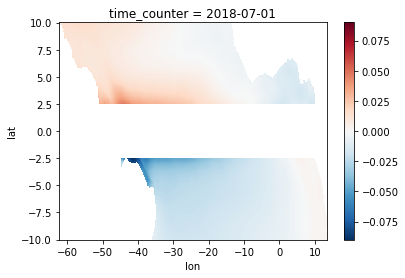

In [23]:
T_E_JRA_MM.isel(time_counter=-1).plot(x='lon')

In [24]:
JRA_TE_trend = calc_10year_trend(T_E_JRA_MM,'time_counter',T_E_JRA_MM.time_counter)
JRA_TE_trend

<xarray.DataArray (time_counter: 120, lat: 403, lon: 1515)>
dask.array<sum-aggregate, shape=(120, 403, 1515), dtype=float64, chunksize=(120, 10, 1515), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2008-08-01 ... 2018-07-01
  * lat           (lat) float64 -9.999 -9.95 -9.9 -9.851 ... 9.9 9.95 9.999
  * lon           (lon) float64 -62.33 -62.28 -62.22 ... 13.27 13.32 13.38

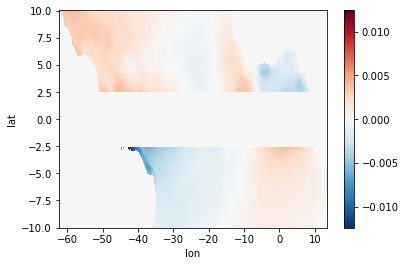

In [25]:
(JRA_TE_trend.isel(time_counter=-1)-JRA_TE_trend.isel(time_counter=0)).plot(x='lon')

<xarray.Dataset>
Dimensions:        (time_counter: 120)
Coordinates:
  * time_counter   (time_counter) datetime64[ns] 2008-08-01 ... 2018-07-01
Data variables:
    ts_orig        (time_counter) float64 11.07 13.88 16.38 ... 21.99 16.52
    ts_reg_slope   float64 4.507e-18
    ts_reg_intc    float64 12.14
    ts_trnd_10yrs  float64 1.41
    ts_trnd        (time_counter) float64 17.63 17.64 17.65 ... 19.03 19.04
    ts_dtnd        (time_counter) float64 11.79 14.59 17.07 ... 22.31 21.3 15.82
    ts_trnd_signf  bool True

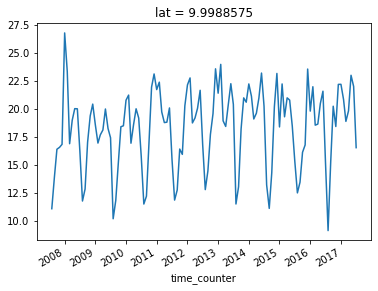

In [26]:
T_E_JRA_div = T_E_JRA_MM.sel(lat=[-10,10],method='nearest').sum('lon').compute()
T_E_JRA_div.diff('lat').plot()
JRA_div_trend = detrend_data(T_E_JRA_div.diff('lat').squeeze(),'time_counter',T_E_JRA_div.time_counter,sig_t=True)
JRA_div_trend

# only 10N/S whole time period

In [27]:
T_Ek_MM =ds_taux.sel(lat=[-10,10],method='nearest').compute()
T_Ek_MM = calc_Ekman(T_Ek_MM)
T_Ek_MM

Task exception was never retrieved
future: <Task finished name='Task-867437' coro=<_wrap_awaitable() done, defined at /gxfs_home/geomar/smomw294/miniconda3/envs/xorca_env/lib/python3.9/asyncio/tasks.py:680> exception=RuntimeError('Command exited with non-zero exit code.\nExit code: 1\nCommand:\nsbatch /tmp/tmpk_35rrmi.sh\nstdout:\n\nstderr:\nsbatch: error: Batch job submission failed: Socket timed out on send/recv operation\n\n')>
Traceback (most recent call last):
  File "/gxfs_home/geomar/smomw294/miniconda3/envs/xorca_env/lib/python3.9/asyncio/tasks.py", line 687, in _wrap_awaitable
    return (yield from awaitable.__await__())
  File "/gxfs_home/geomar/smomw294/miniconda3/envs/xorca_env/lib/python3.9/site-packages/distributed/deploy/spec.py", line 71, in _
    await self.start()
  File "/gxfs_home/geomar/smomw294/miniconda3/envs/xorca_env/lib/python3.9/site-packages/dask_jobqueue/core.py", line 324, in start
    out = await self._submit_job(fn)
  File "/gxfs_home/geomar/smomw294/mi

<xarray.DataArray (forcings: 2, time_counter: 732, lat: 2, lon: 1515)>
array([[[[       nan,        nan,        nan, ..., 0.00163223,
          0.00160823,        nan],
         [0.01611102, 0.01606678, 0.01602686, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ..., 0.00168927,
          0.00170015,        nan],
         [0.01605404, 0.01599083, 0.01593532, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ..., 0.00197707,
          0.00194571,        nan],
         [0.02103202, 0.02087659, 0.02069297, ...,        nan,
                 nan,        nan]],

        ...,

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
...
          0.00281987,        nan],
         [0.00633098, 0.00637775, 0.00644195, ...,        nan,
                 nan,        nan]],

        ...,

        [[       nan,        nan,        nan, ..., 0.00352913,
          0.0035456 ,        nan],
         [0.00446078, 0.00453343, 0.00462499, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ..., 0.00348581,
          0.00344344,        nan],
         [0.00553585, 0.00565876, 0.00579819, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ..., 0.0024419 ,
          0.00242318,        nan],
         [0.00686059, 0.00696498, 0.00709453, ...,        nan,
                 nan,        nan]]]])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1958-01-01 ... 2018-12-01
  * lat           (lat) float32 -9.999 9.999
  * lon           (lon) float32 -62.33 -62.28 -62.22 ... 13.27 13.32 13.38
    umask         (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
  * forcings      (forcings) <U4 'CORE' 'JRA'
    e2u           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    e1u           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan

In [28]:
T_Ek_MM_div = T_Ek_MM.sum('lon').compute()

In [29]:
with xr.set_options(keep_attrs=True):
        T_Ek_MM_div = xr.concat([T_Ek_MM_div.sel(forcings='CORE'),T_Ek_MM_div.sel(forcings='JRA')],
                        'forcings')
T_Ek_MM_div = T_Ek_MM_div.diff('lat').where(T_Ek_MM_div.diff('lat')>0).squeeze().drop('lat')
T_Ek_MM_div

<xarray.DataArray (forcings: 2, time_counter: 732)>
array([[18.70815552, 17.63271773, 19.99382361, ...,         nan,
                nan,         nan],
       [15.54798892, 16.07852357, 18.92801511, ..., 14.73154403,
        22.76476982, 21.56690191]])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1958-01-01 ... 2018-12-01
  * forcings      (forcings) object 'CORE' 'JRA'

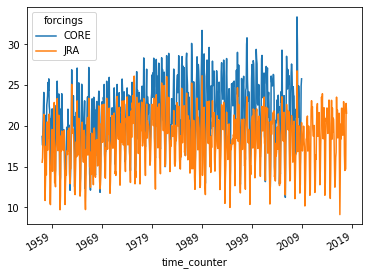

In [30]:
T_Ek_MM_div.plot(hue='forcings')

In [31]:
T_Ek_MM_div

<xarray.DataArray (forcings: 2, time_counter: 732)>
array([[18.70815552, 17.63271773, 19.99382361, ...,         nan,
                nan,         nan],
       [15.54798892, 16.07852357, 18.92801511, ..., 14.73154403,
        22.76476982, 21.56690191]])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1958-01-01 ... 2018-12-01
  * forcings      (forcings) object 'CORE' 'JRA'

<xarray.Dataset>
Dimensions:        (time_counter: 252)
Coordinates:
  * time_counter   (time_counter) datetime64[ns] 1960-01-01 ... 1980-12-01
Data variables:
    ts_orig        (time_counter) float64 19.56 14.43 18.34 ... 23.82 20.42
    ts_reg_slope   float64 5.388e-18
    ts_reg_intc    float64 18.05
    ts_trnd_10yrs  float64 3.556
    ts_trnd        (time_counter) float64 16.35 16.36 16.37 ... 19.87 19.89 19.9
    ts_dtnd        (time_counter) float64 21.35 16.2 20.1 ... 16.48 22.06 18.65
    ts_trnd_signf  bool True

<xarray.Dataset>
Dimensions:        (time_counter: 252)
Coordinates:
  * time_counter   (time_counter) datetime64[ns] 1960-01-01 ... 1980-12-01
Data variables:
    ts_orig        (time_counter) float64 22.1 17.43 21.43 ... 23.23 28.17 24.86
    ts_reg_slope   float64 5.94e-18
    ts_reg_intc    float64 20.24
    ts_trnd_10yrs  float64 3.921
    ts_trnd        (time_counter) float64 18.36 18.38 18.39 ... 22.27 22.28
    ts_dtnd        (time_counter) float64 24.07 19.39 23.37 ... 26.23 22.91
    ts_trnd_signf  bool True

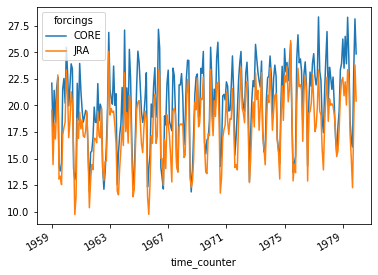

In [32]:
tlim=['1960','1980']
ds_div = T_Ek_MM_div.sel(time_counter=slice(*tlim))
T_Ek_MM_div_trend_JRA = detrend_data(ds_div.sel(forcings='JRA'),'time_counter',ds_div.time_counter,sig_t=True)
T_Ek_MM_div_trend_CORE = detrend_data(ds_div.sel(forcings='CORE'),'time_counter',ds_div.time_counter,sig_t=True)
display(T_Ek_MM_div_trend_JRA)
display(T_Ek_MM_div_trend_CORE)
ds_div.plot(hue='forcings')

<xarray.Dataset>
Dimensions:        (time_counter: 360)
Coordinates:
  * time_counter   (time_counter) datetime64[ns] 1980-01-01 ... 2009-12-01
Data variables:
    ts_orig        (time_counter) float64 22.65 20.91 22.23 ... 19.36 20.41
    ts_reg_slope   float64 -1.606e-18
    ts_reg_intc    float64 19.94
    ts_trnd_10yrs  float64 -1.516
    ts_trnd        (time_counter) float64 19.43 19.43 19.43 ... 17.92 17.92
    ts_dtnd        (time_counter) float64 21.9 20.17 21.49 ... 17.77 20.12 21.18
    ts_trnd_signf  bool True

<xarray.Dataset>
Dimensions:        (time_counter: 360)
Coordinates:
  * time_counter   (time_counter) datetime64[ns] 1980-01-01 ... 2009-12-01
Data variables:
    ts_orig        (time_counter) float64 26.26 23.52 26.51 ... 24.94 25.78
    ts_reg_slope   float64 -9.289e-19
    ts_reg_intc    float64 23.14
    ts_trnd_10yrs  float64 -0.877
    ts_trnd        (time_counter) float64 22.85 22.84 22.84 ... 21.97 21.97
    ts_dtnd        (time_counter) float64 25.84 23.09 26.09 ... 19.3 25.38 26.24
    ts_trnd_signf  bool True

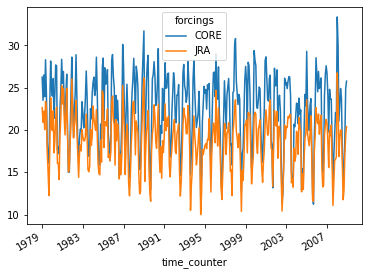

In [33]:
tlim=['1980','2009']
ds_div = T_Ek_MM_div.sel(time_counter=slice(*tlim))
T_Ek_MM_div_trend_JRA = detrend_data(ds_div.sel(forcings='JRA'),'time_counter',ds_div.time_counter,sig_t=True)
T_Ek_MM_div_trend_CORE = detrend_data(ds_div.sel(forcings='CORE'),'time_counter',ds_div.time_counter,sig_t=True)
display(T_Ek_MM_div_trend_JRA)
display(T_Ek_MM_div_trend_CORE)
ds_div.plot(hue='forcings')

<xarray.Dataset>
Dimensions:        (time_counter: 120)
Coordinates:
  * time_counter   (time_counter) datetime64[ns] 2008-08-01 ... 2018-07-01
Data variables:
    ts_orig        (time_counter) float64 11.07 13.88 16.38 ... 21.99 16.52
    ts_reg_slope   float64 4.507e-18
    ts_reg_intc    float64 12.14
    ts_trnd_10yrs  float64 1.41
    ts_trnd        (time_counter) float64 17.63 17.64 17.65 ... 19.03 19.04
    ts_dtnd        (time_counter) float64 11.79 14.59 17.07 ... 22.31 21.3 15.82
    ts_trnd_signf  bool True

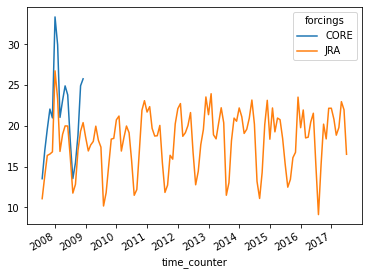

In [34]:
tlim=['2008-Aug','2018-Jul']
ds_div = T_Ek_MM_div.sel(time_counter=slice(*tlim))
T_Ek_MM_div_trend_JRA = detrend_data(ds_div.sel(forcings='JRA'),'time_counter',ds_div.time_counter,sig_t=True)
T_Ek_MM_div_trend_CORE = detrend_data(ds_div.sel(forcings='CORE'),'time_counter',ds_div.time_counter,sig_t=True)
ds_div.plot(hue='forcings')
display(T_Ek_MM_div_trend_JRA)
# display(T_Ek_MM_div_trend_CORE)

# T_E_MM else

In [35]:
# T_E_MM = calc_Ekman(ds_taux)

In [36]:
# def weigthed_annual_mean(T_E_MM):
#     month_length = T_E_MM.time_counter.dt.days_in_month
#     # Calculate the weights by grouping by 'time.months'.
#     weights = (
#         month_length.groupby("time_counter.year") / month_length.groupby("time_counter.year").sum()
#     )

#     # Test that the sum of the weights for each season is 1.0
#     np.testing.assert_allclose(weights.groupby("time_counter.year").sum().values, np.ones(61))
#     return(T_E_MM * weights).groupby("time_counter.year").sum(dim="time_counter")

In [37]:
# T_E_AM_w = weigthed_annual_mean(T_E_MM)
# T_E_AM_w

# T_E_AM_uw = T_E_MM.sel(time_counter=slice('1980','2009')).mean(dim="time_counter").compute()

# # T_E_ave_w = T_E_AM_w.sel(year=slice(1980,2009)).mean(dim="year").compute()

# T_E_ave_w.plot(col='forcings')

# T_E_ave_w.sum('lon').plot(x='lat',hue='forcings')
# plt.grid()

# g = T_E_ave_w.sel(lat=[-10,10],method='nearest').cumsum('lon').plot.line(x='lon',hue='forcings',col='lat')
# for ax in g.axes.flat:
#     ax.grid(which='both')

# T_E_ave_w.sel(lat=[-10,10],method='nearest').cumsum('lon').diff('lat').squeeze().plot.line(x='lon',hue='forcings')
# plt.grid()

# lati = 10
# T_E_ave_w.sel(lat=[-lati,lati],method='nearest').sum('lon')

# T_E_ave_w.sel(lat=[-lati,lati],method='nearest').sum('lon').diff('lat')

### Calculate Climatology 1980-2009

In [38]:
%%time
if save_data_clim:
    JRA_taux_ave_clim = JRA_taux.sel(time_counter=slice(t_cyc_min,t_cyc_max)).groupby('time_counter.month').mean('time_counter').compute()
    CORE_taux_ave_clim = CORE_taux.sel(time_counter=slice(t_cyc_min,t_cyc_max)).groupby('time_counter.month').mean('time_counter').compute()

    JRA_taux_ave_clim.name = "taux"
    JRA_taux_ave_clim.attrs['title'] = f"JRA taux clim {t_cyc_min}-{t_cyc_max}"
    JRA_taux_ave_clim.attrs['expirement_id'] = JRA_exp_id
    JRA_taux_ave_clim.attrs['long_name']="Zonal Wind Stress"
    JRA_taux_ave_clim.attrs['units']="N/m2"
    JRA_taux_ave_clim.attrs['history']=f"Monthly mean clim {t_cyc_min}-{t_cyc_max} calculated from {out_dir_data}/{nest_prefix}{JRA_exp_id}_mm_*_*_grid_U.nc using script INALT20_wind_forcing_comparison_taux.ipynb"
    JRA_taux_ave_clim.to_netcdf((out_dir_data / f"{nest_prefix}{JRA_exp_id[:-1]}X_JRA_taux_mm_clim_{region_str}_{t_cyc_min}_{t_cyc_max}.nc"))

    CORE_taux_ave_clim.name = "taux"
    CORE_taux_ave_clim.attrs['title'] = f"CORE taux clim {t_cyc_min}-{t_cyc_max}"
    CORE_taux_ave_clim.attrs['expirement_id'] = CORE_exp_id
    CORE_taux_ave_clim.attrs['long_name']="Zonal Wind Stress"
    CORE_taux_ave_clim.attrs['units']="N/m2"
    CORE_taux_ave_clim.attrs['history']=f"Monthly mean clim {t_cyc_min}-{t_cyc_max} calculated from {out_dir_data}/{nest_prefix}{JRA_exp_id}_mm_*_*_grid_U.nc using script INALT20_wind_forcing_comparison_taux.ipynb"
    CORE_taux_ave_clim.to_netcdf((out_dir_data / f"{nest_prefix}{CORE_exp_id}_CORE_taux_mm_clim_{region_str}_{t_cyc_min}_{t_cyc_max}.nc"))


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


# load data again

In [39]:
with dask.config.set(scheduler='synchronous'):
    JRA_taux_ave_clim = xr.open_dataarray(
        (out_dir_data / f"{nest_prefix}{JRA_exp_id[:-1]}X_JRA_taux_mm_clim_{region_str}_{t_cyc_min}_{t_cyc_max}.nc"),
            decode_cf=True,
            chunks={"lat":chu_y,"lon":chu_x})
    CORE_taux_ave_clim = xr.open_dataarray(
        (out_dir_data / f"{nest_prefix}{CORE_exp_id}_CORE_taux_mm_clim_{region_str}_{t_cyc_min}_{t_cyc_max}.nc"),
            decode_cf=True,
            chunks={"lat":chu_y,"lon":chu_x})

JRA_taux_ave_clim = JRA_taux_ave_clim.where(JRA_taux_ave_clim.umask==1,drop=True)
CORE_taux_ave_clim = CORE_taux_ave_clim.where(CORE_taux_ave_clim.umask==1,drop=True)

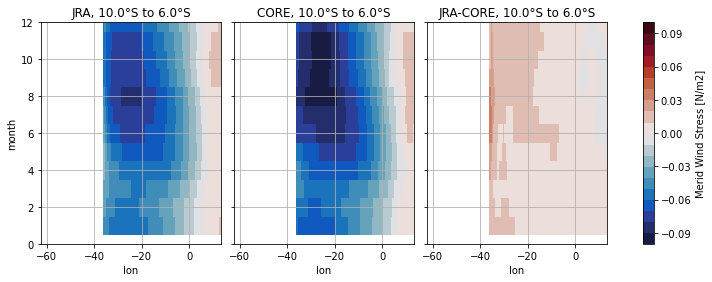

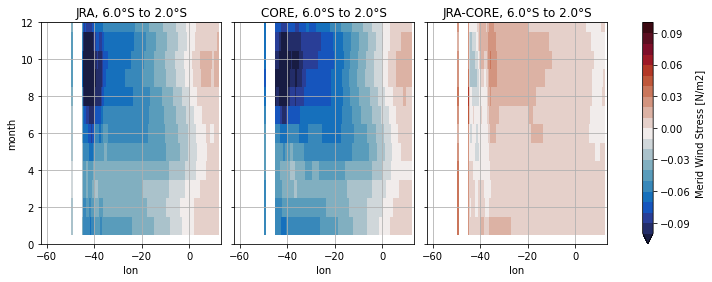

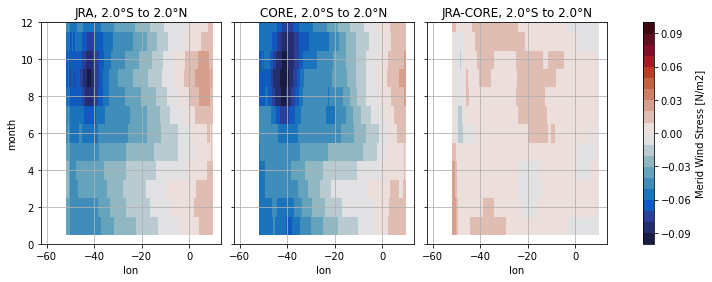

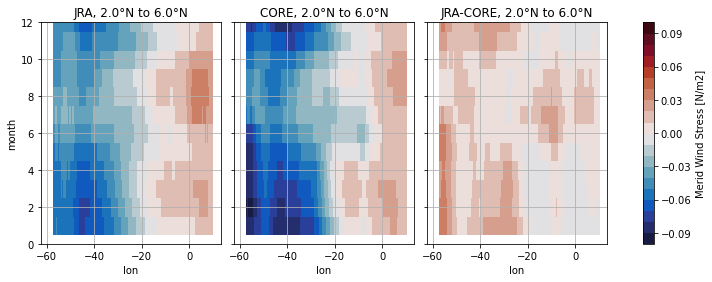

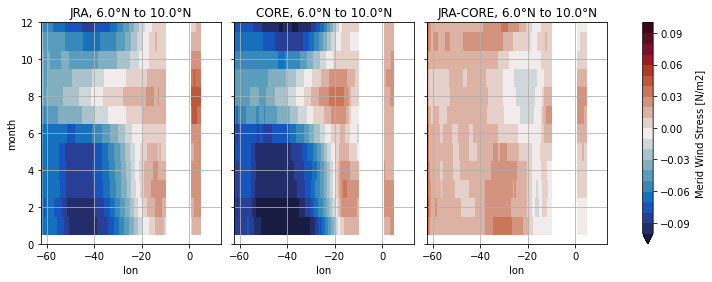

In [40]:
with xr.set_options(keep_attrs=True):
    tau_clim = xr.concat([JRA_taux_ave_clim,CORE_taux_ave_clim,(JRA_taux_ave_clim-CORE_taux_ave_clim)],
                        'forcings')
tau_clim.coords['forcing'] = (['forcings'],['JRA','CORE','JRA-CORE'],)


for kk,val in enumerate(lat_bins[:-1]):

    y_lim=lat_bins[kk:kk+2]
    s_str,n_str=lat_str(y_lim)

    ds_dummy=tau_clim.sel(lat=slice(y_lim[0],y_lim[1]))
    
    ds_dummy.name = 'Merid Wind Stress [N/m2]'
    
    p = ds_dummy.mean('lat').plot(
        x='lon',y='month',col='forcings',col_wrap=3,
        ylim=[0,12],aspect=.8, size=4,
        levels=21,vmin=-0.1,vmax=0.1,
        cmap=co.cm.balance)

    for idx,ax in enumerate(p.axes.flat):
        ax.grid()
        ax.set_title('%.10s, ' %tau_clim.forcing[idx].values 
                     +str(np.abs(y_lim[0]))+'\N{DEGREE SIGN}'+s_str[-1]+' to '
                     +str(np.abs(y_lim[1]))+'\N{DEGREE SIGN}'+n_str[-1])
    
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_hov_zo_clim}{t_cyc_min}_{t_cyc_max}_{s_str}{n_str}{fig_format}"),dpi=300)

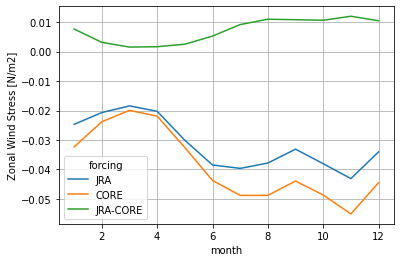

In [41]:
ds_dummy = tau_clim.sel(lat=slice(-3,3),lon=slice(-30,-20)).mean(['lat','lon'])
ds_dummy.name = 'Zonal Wind Stress [N/m2]'
ds_dummy.plot.line(x='month',hue='forcing')
plt.grid()

### Calculate wind stress anomlies with respect to climatology {t_cyc_min}-{t_cyc_max}

In [42]:
%%time
if save_data_anom:
    for yy in range(2010,2018):
        year = str(yy)
        JRA_taux_mmA = JRA_taux.sel(time_counter=year).groupby('time_counter.month') - JRA_taux_ave_clim
        
        if yy<2010:
            CORE_taux_mmA= CORE_taux.sel(time_counter=year).groupby('time_counter.month') - CORE_taux_ave_clim
        else:
            CORE_taux_mmA= CORE_taux.sel(time_counter='2009')*np.NaN
            CORE_taux_mmA.coords['time_counter'] = JRA_taux_mmA.time_counter

        taux_mmA =xr.merge([
            JRA_taux_mmA.rename('JRA_taux'),
            CORE_taux_mmA.rename('CORE_taux')
            ])

        taux_mmA.attrs['title']=f"INALT20 mm zonal wind stress anomalies relto {t_cyc_min}-{t_cyc_max} [N/m2]"
        taux_mmA.lon.attrs['standard_name'] = 'longitude'
        taux_mmA.lon.attrs['long_name'] = "Longitude"
        taux_mmA.lon.attrs['units'] = 'degrees_east'
        taux_mmA.lat.attrs['standard_name'] = 'latitude'
        taux_mmA.lat.attrs['long_name'] = "Latitude"
        taux_mmA.lat.attrs['units'] = 'degrees_north'
        taux_mmA.JRA_taux.attrs['long_name'] = 'Zonal wind stress anomaly'
        taux_mmA.JRA_taux.attrs['expirement_id'] = JRA_exp_id
        taux_mmA.CORE_taux.attrs['long_name'] = 'Zonal wind stress anomaly'
        taux_mmA.CORE_taux.attrs['expirement_id'] = CORE_exp_id
        taux_mmA.JRA_taux.attrs['units'] = 'N/m2'
        taux_mmA.CORE_taux.attrs['units'] = 'N/m2'
        taux_mmA.attrs['contact'] = 'Kristin Burmeister - kristin.burmeister@sams.ac.uk'
        taux_mmA.attrs['history'] = f"Monthly mean anom relto {t_cyc_min}-{t_cyc_max} calculated from {out_dir_data}/{nest_prefix}*_mm_[clim_]*_*_grid_U.nc using script {script_name}"
        display(taux_mmA)
        taux_mmA.to_netcdf((out_dir_data / f"{nest_prefix}INALT20_JRA_CORE_{year}_taux_mmA_{region_str}_clim_{t_cyc_min}_{t_cyc_max}.nc"),
                    engine = 'netcdf4')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs


In [43]:
fn = list(sorted(
    (out_dir_data).glob(
        f"{nest_prefix}INALT20_JRA_CORE_????_taux_mmA_{region_str}_clim_{t_cyc_min}_{t_cyc_max}.nc"
)))

with dask.config.set(scheduler='synchronous'):
        taux_mmA = xr.open_mfdataset(
                fn,
                decode_cf=True,
                chunks={"time_counter":chu_t, 
                      "lat":chu_y,"lon":chu_x})

## Calculate annual averages

In [44]:
%%time
if save_data_AM:
    taux_AM_anom= taux_mmA.groupby('time_counter.year').mean('time_counter').compute()

    taux_AM_anom.lon.attrs['standard_name'] = 'longitude'
    taux_AM_anom.lon.attrs['long_name'] = "Longitude"
    taux_AM_anom.lon.attrs['units'] = 'degrees_east'
    taux_AM_anom.lat.attrs['standard_name'] = 'latitude'
    taux_AM_anom.lat.attrs['long_name'] = "Latitude"
    taux_AM_anom.lat.attrs['units'] = 'degrees_north'
    taux_AM_anom.JRA_taux.attrs['long_name'] = 'zonal wind stress anomaly'
    taux_AM_anom.CORE_taux.attrs['long_name'] = 'zonal wind stress anomaly'
    taux_AM_anom.JRA_taux.attrs['units'] = 'N/m2'
    taux_AM_anom.CORE_taux.attrs['units'] = 'N/m2'
    taux_AM_anom.attrs['title'] = f'INALT20 zonal wind stress anomalies relto {t_cyc_min}-{t_cyc_max}'
    taux_AM_anom.attrs['contact'] = 'Kristin Burmeister - kristin.burmeister@sams.ac.uk'
    taux_AM_anom.attrs['history'] = f"Annual mean anom relto {t_cyc_min}-{t_cyc_max} calculated from {out_dir_data}/{nest_prefix}*_mm_[clim_]*_*_grid_U.nc using script {script_name}"
    taux_AM_anom.to_netcdf((out_dir_data / f"{nest_prefix}INALT20_JRA_CORE_AM_taux_mmA_{region_str}_clim_{t_cyc_min}_{t_cyc_max}.nc"),
                    engine = 'netcdf4')
else:
    with dask.config.set(scheduler='synchronous'):
        taux_AM_anom = xr.open_dataset(
                (out_dir_data / f"{nest_prefix}INALT20_JRA_CORE_AM_taux_mmA_{region_str}_clim_{t_cyc_min}_{t_cyc_max}.nc"),
                decode_cf=True,
                chunks={"lat":chu_y,"lon":chu_x})
        
taux_AM_anom

CPU times: user 9.54 ms, sys: 1.98 ms, total: 11.5 ms
Wall time: 94.9 ms


<xarray.Dataset>
Dimensions:    (lat: 403, lon: 1515, year: 61)
Coordinates:
  * lat        (lat) float32 -9.999 -9.95 -9.9 -9.851 ... 9.851 9.9 9.95 9.999
  * lon        (lon) float32 -62.33 -62.28 -62.22 -62.17 ... 13.27 13.32 13.38
    umask      (lat, lon) int8 dask.array<chunksize=(100, 100), meta=np.ndarray>
  * year       (year) int64 1958 1959 1960 1961 1962 ... 2015 2016 2017 2018
Data variables:
    JRA_taux   (year, lat, lon) float64 dask.array<chunksize=(61, 100, 100), meta=np.ndarray>
    CORE_taux  (year, lat, lon) float64 dask.array<chunksize=(61, 100, 100), meta=np.ndarray>
Attributes:
    title:    INALT20 zonal wind stress anomalies relto 1980-2009
    contact:  Kristin Burmeister - kristin.burmeister@sams.ac.uk
    history:  Annual mean anom relto 1980-2009 calculated from ../data/INALT2...

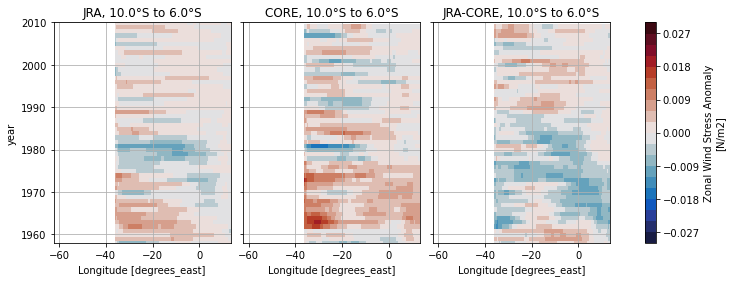

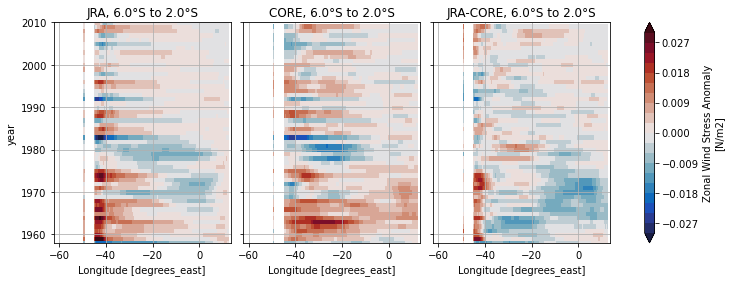

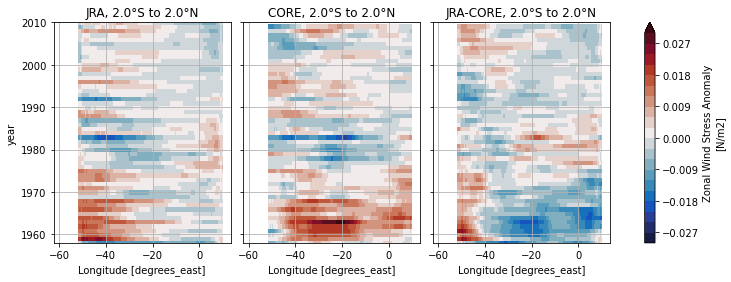

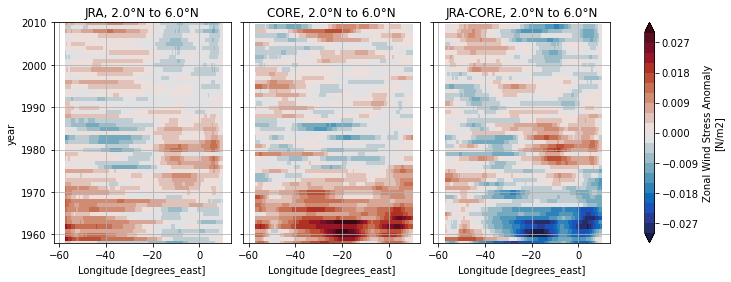

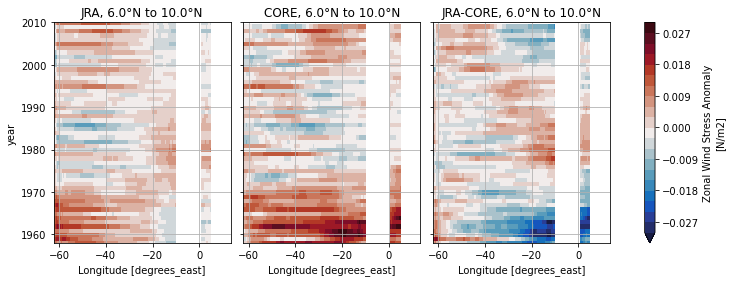

In [45]:
with xr.set_options(keep_attrs=True):
    ds_test = xr.concat([taux_AM_anom.JRA_taux,taux_AM_anom.CORE_taux,(taux_AM_anom.JRA_taux-taux_AM_anom.CORE_taux)],
                        'forcings')
ds_test.coords['forcings'] = (['forcings'],['JRA','CORE','JRA-CORE'],)

for kk,val in enumerate(lat_bins[:-1]):

    y_lim=lat_bins[kk:kk+2]
    s_str,n_str = lat_str(y_lim)

    ds_t=ds_test.sel(lat=slice(y_lim[0],y_lim[1]))
    
    ds_t.name = 'Zonal Wind Stress Anomaly [N/m2]'
    
    p = ds_t.mean('lat').plot(
        x='lon',y='year',col='forcings',col_wrap=3,
        ylim=[1958,2010],aspect=.8, size=4,
        levels=21,vmin=-0.03,vmax=0.03,
        cmap=co.cm.balance)

    for idx,ax in enumerate(p.axes.flat):
        ax.grid()
        ax.set_title('%.10s, ' %ds_test.forcings[idx].values 
                     +str(np.abs(y_lim[0]))+'\N{DEGREE SIGN}'+s_str[-1]+' to '
                     +str(np.abs(y_lim[1]))+'\N{DEGREE SIGN}'+n_str[-1])
    
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_hov_zo}{s_str}{n_str}{fig_format}"),dpi=300)

In [46]:
font = {'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

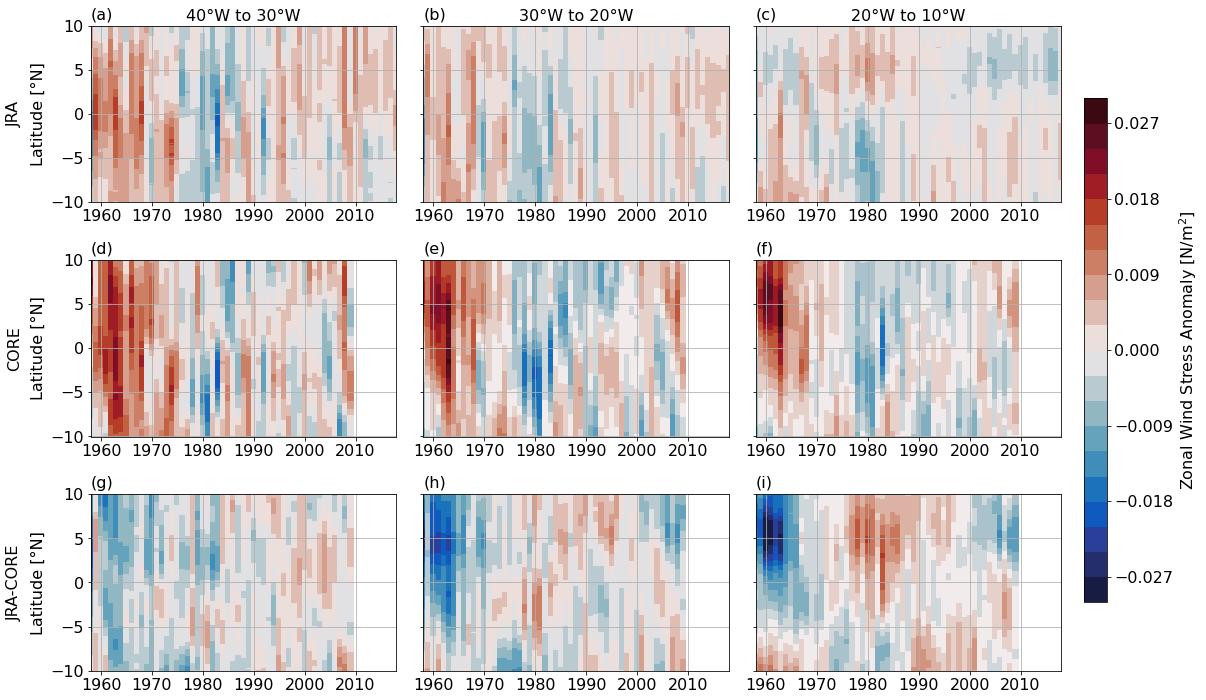

In [60]:
xbndsw,xbndsm,xbndse, = [-40,-30],[-30,-20],[-20,-10]

def col_str(xbnds):
    min_str,max_str = lon_str(xbnds)
    test = f'{abs(xbnds[0])}\N{DEGREE SIGN}{min_str[-1]} to {abs(xbnds[1])}\N{DEGREE SIGN}{max_str[-1]}'
    return test

cols = [col_str(xbndsw),col_str(xbndsm),col_str(xbndse)]
rows = ds_test.forcings.values

ds_t_w=ds_test.sel(lon=slice(*xbndsw)).mean('lon')
ds_t_m=ds_test.sel(lon=slice(*xbndsm)).mean('lon')
ds_t_e=ds_test.sel(lon=slice(*xbndse)).mean('lon')

name = r'Zonal Wind Stress Anomaly [N/m$^2$]'

fig,axs = plt.subplots(3,3,figsize=(16,10),sharey=True)

def plot_the_wind(ds,axs):
    cbar_kwargs = {'pad': 0.01}
    p = ds.plot(
        y='lat',x='year',ax=axs,
        xlim=[1958,2018],        
        levels=21,vmin=-0.03,vmax=0.03,
        cmap=co.cm.balance,
        add_colorbar=False,
#         cbar_kwargs=cbar_kwargs,
    )
    return p

p = plot_the_wind(ds_t_w.sel(forcings='JRA'),axs[0,0])
plot_the_wind(ds_t_m.sel(forcings='JRA'),axs[0,1])
plot_the_wind(ds_t_e.sel(forcings='JRA'),axs[0,2])

plot_the_wind(ds_t_w.sel(forcings='CORE'),axs[1,0])
plot_the_wind(ds_t_m.sel(forcings='CORE'),axs[1,1])
plot_the_wind(ds_t_e.sel(forcings='CORE'),axs[1,2])

plot_the_wind(ds_t_w.sel(forcings='JRA-CORE'),axs[2,0])
plot_the_wind(ds_t_m.sel(forcings='JRA-CORE'),axs[2,1])
plot_the_wind(ds_t_e.sel(forcings='JRA-CORE'),axs[2,2])

for idx,ax in enumerate(axs.flat):
    ax.grid()
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')

pad = 5 # in points

for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                 ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                 ha='right', va='center',rotation=90,)
    ax.set_ylabel('Latitude [°N]')

abc_label = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)']

for i,ax in enumerate(axs.flat):
    ax.text(.0, 1.02, abc_label[i], ha='left', va='bottom', transform=ax.transAxes)

plt.tight_layout()

fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb =fig.colorbar(p, cax=cbar_ax)
cb.set_label(f'{name}')

fig.savefig((out_dir_fig / f"{nest_prefix}{out_fig_hov_me}all_lon{fig_format}"),dpi=300,bbox_inches='tight',)

In [59]:
for i,ax in enumerate(axs.flat):
    print(i)

0
1
2
3
4
5
6
7
8


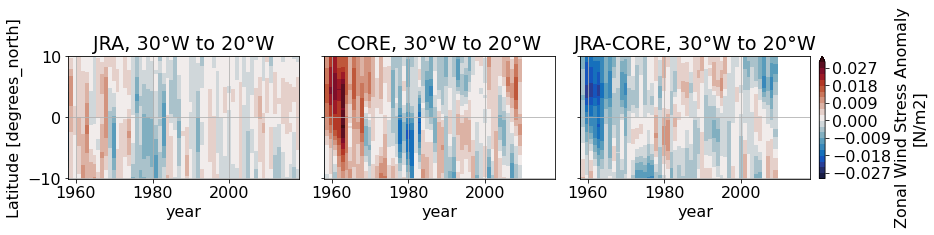

In [104]:
xbnds = [-30,-20]
min_str,max_str = lon_str(xbnds)

ds_t=ds_test.sel(lon=slice(xbnds[0],xbnds[1])).mean('lon')

ds_t.name = 'Zonal Wind Stress Anomaly [N/m2]'

cbar_kwargs = {'pad': 0.01}
p = ds_t.plot(
    y='lat',x='year',col='forcings',col_wrap=3,
    xlim=[1958,2018],aspect=1.4, size=3,
    levels=21,vmin=-0.03,vmax=0.03,
    cmap=co.cm.balance,
    cbar_kwargs=cbar_kwargs,
)

for idx,ax in enumerate(p.axes.flat):
    ax.grid()
    ax.set_title('%.10s, ' %ds_test.forcings[idx].values 
                     +str(np.abs(xbnds[0]))+'\N{DEGREE SIGN}'+min_str[-1]+' to '
                     +str(np.abs(xbnds[1]))+'\N{DEGREE SIGN}'+max_str[-1])

plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_hov_me}{min_str}{max_str}{fig_format}"),dpi=300,bbox_inches='tight',)

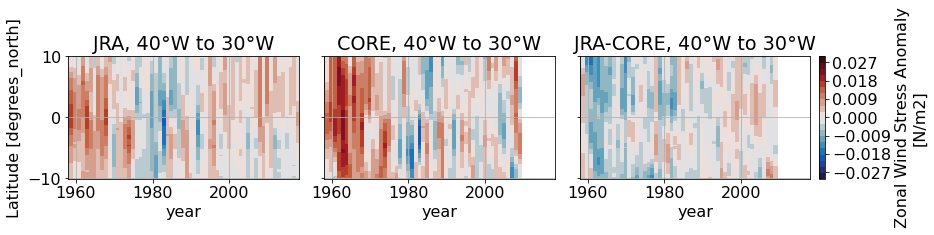

In [105]:
xbnds = [-40,-30]
min_str,max_str = lon_str(xbnds)

ds_t=ds_test.sel(lon=slice(xbnds[0],xbnds[1])).mean('lon')

ds_t.name = 'Zonal Wind Stress Anomaly [N/m2]'

cbar_kwargs = {'pad': 0.01}
p = ds_t.plot(
    y='lat',x='year',col='forcings',col_wrap=3,
    xlim=[1958,2018],aspect=1.4, size=3,
    levels=21,vmin=-0.03,vmax=0.03,
    cmap=co.cm.balance,
    cbar_kwargs=cbar_kwargs,
)

for idx,ax in enumerate(p.axes.flat):
    ax.grid()
    ax.set_title('%.10s, ' %ds_test.forcings[idx].values 
                     +str(np.abs(xbnds[0]))+'\N{DEGREE SIGN}'+min_str[-1]+' to '
                     +str(np.abs(xbnds[1]))+'\N{DEGREE SIGN}'+max_str[-1])

plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_hov_me}{min_str}{max_str}{fig_format}"),dpi=300,bbox_inches='tight',)

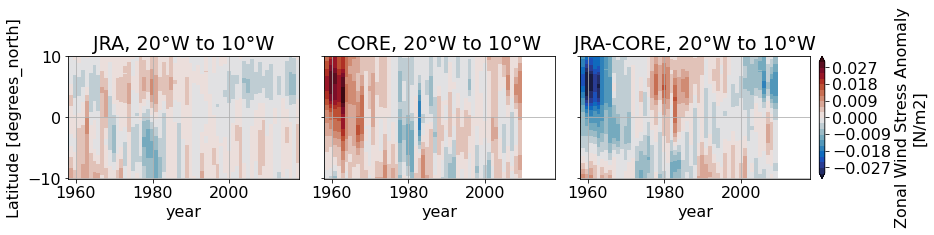

In [106]:
xbnds = [-20,-10]
min_str,max_str = lon_str(xbnds)

ds_t=ds_test.sel(lon=slice(xbnds[0],xbnds[1])).mean('lon')

ds_t.name = 'Zonal Wind Stress Anomaly [N/m2]'

cbar_kwargs = {'pad': 0.01}
p = ds_t.plot(
    y='lat',x='year',col='forcings',col_wrap=3,
    xlim=[1958,2018],aspect=1.4, size=3,
    levels=21,vmin=-0.03,vmax=0.03,
    cmap=co.cm.balance,
    cbar_kwargs=cbar_kwargs,
)

for idx,ax in enumerate(p.axes.flat):
    ax.grid()
    ax.set_title('%.10s, ' %ds_test.forcings[idx].values 
                     +str(np.abs(xbnds[0]))+'\N{DEGREE SIGN}'+min_str[-1]+' to '
                     +str(np.abs(xbnds[1]))+'\N{DEGREE SIGN}'+max_str[-1])

plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_hov_me}{min_str}{max_str}{fig_format}"),dpi=300,bbox_inches='tight',)

In [107]:
da = ds_test.sel(lat=slice(-3,3),lon=slice(-40,10))
da = (da
      .mean('lat')
      .groupby(((da.lon//10) + 0.5) * 10)
      .mean(dim='lon'))
da

<xarray.DataArray 'JRA_taux' (forcings: 3, year: 61, lon: 5)>
dask.array<transpose, shape=(3, 61, 5), dtype=float64, chunksize=(1, 61, 1), chunktype=numpy.ndarray>
Coordinates:
  * lon       (lon) float64 -35.0 -25.0 -15.0 -5.0 5.0
  * year      (year) int64 1958 1959 1960 1961 1962 ... 2014 2015 2016 2017 2018
  * forcings  (forcings) <U8 'JRA' 'CORE' 'JRA-CORE'

<Figure size 432x288 with 0 Axes>

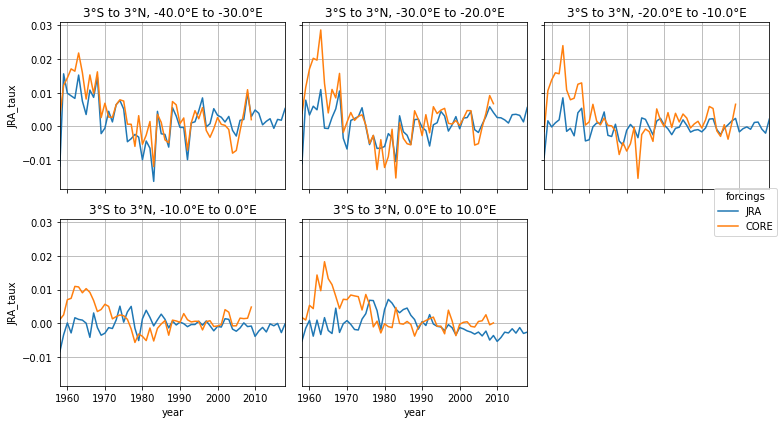

In [33]:
fig = plt.figure()
p=da.sel(forcings=['JRA','CORE']).plot.line(
    x='year',col='lon',
    col_wrap=3,sharey=True,
    xlim=[1958,2018])

for idx,ax in enumerate(p.axes.flat[:-1]):
    ax.set_title('3\N{DEGREE SIGN}S to 3\N{DEGREE SIGN}N, '
                 +str(np.array(da.lon[idx])-5)
                 +'\N{DEGREE SIGN}E to '
                 +str(np.array(da.lon[idx])+5)
                 +'\N{DEGREE SIGN}E')
    ax.grid();
    
plt.tight_layout()
plt.savefig((out_dir_fig / f"{nest_prefix}{out_file_fig1}{fig_format}"),dpi=300)

<Figure size 432x288 with 0 Axes>

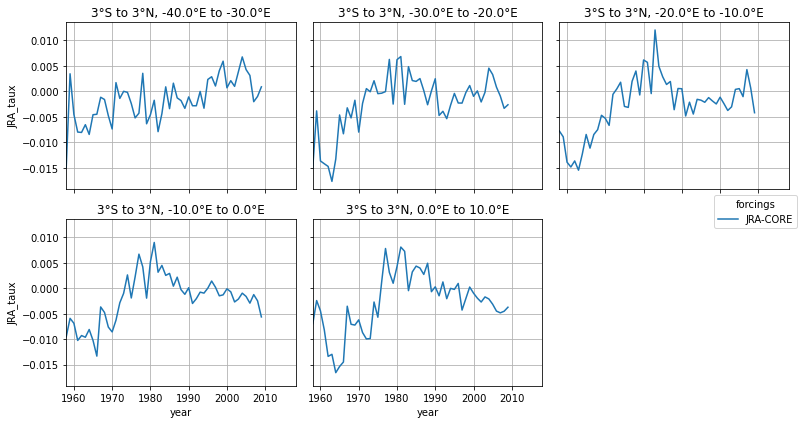

In [34]:
fig = plt.figure()
p=da.sel(forcings=['JRA-CORE']).plot.line(
    x='year',col='lon',
    col_wrap=3,sharey=True,
    xlim=[1958,2018])

for idx,ax in enumerate(p.axes.flat[:-1]):
    ax.set_title('3\N{DEGREE SIGN}S to 3\N{DEGREE SIGN}N, '
                 +str(np.array(da.lon[idx])-5)
                 +'\N{DEGREE SIGN}E to '
                 +str(np.array(da.lon[idx])+5)
                 +'\N{DEGREE SIGN}E')
    ax.grid();
    
plt.tight_layout()
plt.savefig((out_dir_fig / f"{nest_prefix}{out_file_fig2}{fig_format}"),dpi=300)

Differences in multidecadal variability increases towards the east. Which region is more important in driving current variability?

But only for the period before 1990 - afterwards they agree quite well in the easter basin, whereas, at approxiately the same time (late 1990s), they begin to deviate from each other in the western boxes.